In [1]:
import torch
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

from scarches.dataset.trvae.data_handling import remove_sparsity
from lataq.models import EMBEDCVAE
from lataq.exp_dict import EXPERIMENT_INFO

sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=500)
plt.rcParams['figure.figsize'] = (5, 5)
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

%load_ext autoreload
%autoreload 2

In [2]:
PARAMS = {
    'EPOCHS': 50,                                      #TOTAL TRAINING EPOCHS
    'N_PRE_EPOCHS': 40,                                #EPOCHS OF PRETRAINING WITHOUT LANDMARK LOSS
    #'DATA_DIR': '../../lataq_reproduce/data',          #DIRECTORY WHERE THE DATA IS STORED
    #'DATA': 'pancreas',                                #DATA USED FOR THE EXPERIMENT
    'EARLY_STOPPING_KWARGS': {                         #KWARGS FOR EARLY STOPPING
        "early_stopping_metric": "val_landmark_loss",  ####value used for early stopping
        "mode": "min",                                 ####choose if look for min or max
        "threshold": 0,
        "patience": 20,
        "reduce_lr": True,
        "lr_patience": 13,
        "lr_factor": 0.1,
    },
    'LABELED_LOSS_METRIC': 'dist',           
    'UNLABELED_LOSS_METRIC': 'dist',
    'LATENT_DIM': 25,
    'ALPHA_EPOCH_ANNEAL': 1e3,
    'CLUSTERING_RES': 2,
    'HIDDEN_LAYERS': 3,
    'ETA': 5,
}

In [3]:
adata_raw = sc.read(
    '../data/Meyer_2021_raw.h5ad'
)

In [4]:
adata = sc.read(
    '../data/HLCA_meyer_adata_full_tcnorm_log1p.h5ad'
)

In [5]:
adata_counts = sc.read(
    '../data/hlca_counts_commonvars.h5ad'
)

In [6]:
adata_meyer = adata[adata.obs['study'] == 'Meyer_2021']

In [7]:
adata_raw.var = adata_raw.var.set_index('gene_symbols')
adata_raw = adata_raw[:, ~adata_raw.var.index.duplicated(keep='first')]

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/anndata/_core/anndata.py:794: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['RP11-34P13.3', 'FAM138A', 'OR4F5', 'RP11-34P13.7', 'RP11-34P13.8']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)


In [8]:
adata_raw.obs = adata_meyer.obs.reindex(adata_raw.obs.index).copy()
adata_raw = adata_raw[:, adata_counts.var_names]
adata_raw

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


View of AnnData object with n_obs × n_vars = 128628 × 1897
    obs: 'sample', 'original_celltype_ann', 'study_long', 'study', 'last_author_PI', 'subject_ID', 'subject_ID_as_published', 'pre_or_postnatal', 'age_in_years', 'age_range', 'sex', 'ethnicity', 'mixed_ethnicity', 'smoking_status', 'smoking_history', 'BMI', 'known_lung_disease', 'condition', 'subject_type', 'cause_of_death', 'sample_type', 'anatomical_region_coarse', 'anatomical_region_detailed', 'tissue_dissociation_protocol', 'cells_or_nuclei', 'single_cell_platform', "3'_or_5'", 'enrichment', 'sequencing_platform', 'reference_genome_coarse', 'ensembl_release_reference_genome', 'cell_ranger_version', 'disease_status', 'fresh_or_frozen', 'cultured', 'cell_viability_%', 'comments', 'Processing_site', 'dataset', 'anatomical_region_level_1', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4

In [9]:
adata_raw.obs['ann_finest_level'] = [
        adata_raw.obs.loc[cell, f"original_ann_level_{highest_lev}"]
        for cell, highest_lev in zip(
            adata_raw.obs.index, adata_raw.obs.original_ann_highest_res
        )
]

Trying to set attribute `.obs` of view, copying.


In [10]:
adata_raw.obs['ann_finest_level']

AACTTTCAGATGTGGC-WSSS8123924          Interstitial macrophages
ACCTTTAGTGAGTGAC-WSSS8123924                       Fibroblasts
ACGATACTCCGCTGTT-WSSS8123924                      Lymphatic EC
ACTGAACGTAGTGAAT-WSSS8123924                       Fibroblasts
AGAGTGGTCAACACTG-WSSS8123924                       Fibroblasts
                                                ...           
TTTGTCAGTTATCCGA-HCATisStab7732262                 CD4 T cells
TTTGTCAGTTCAGTAC-HCATisStab7732262                  Mast cells
TTTGTCATCACCGGGT-HCATisStab7732262                    NK cells
TTTGTCATCGCGTTTC-HCATisStab7732262         Gamma-delta T cells
TTTGTCATCTAACGGT-HCATisStab7732262              CD4T cells TRM
Name: ann_finest_level, Length: 128628, dtype: object

In [11]:
condition_key = 'dataset'
cell_type_key = ['ann_finest_level']

In [12]:
lataq_query = EMBEDCVAE.load_query_data(
    adata=adata_raw,
    reference_model='hlca_core_dataset/',
    labeled_indices=[],
)

AnnData object with n_obs × n_vars = 128628 × 1897
    obs: 'sample', 'original_celltype_ann', 'study_long', 'study', 'last_author_PI', 'subject_ID', 'subject_ID_as_published', 'pre_or_postnatal', 'age_in_years', 'age_range', 'sex', 'ethnicity', 'mixed_ethnicity', 'smoking_status', 'smoking_history', 'BMI', 'known_lung_disease', 'condition', 'subject_type', 'cause_of_death', 'sample_type', 'anatomical_region_coarse', 'anatomical_region_detailed', 'tissue_dissociation_protocol', 'cells_or_nuclei', 'single_cell_platform', "3'_or_5'", 'enrichment', 'sequencing_platform', 'reference_genome_coarse', 'ensembl_release_reference_genome', 'cell_ranger_version', 'disease_status', 'fresh_or_frozen', 'cultured', 'cell_viability_%', 'comments', 'Processing_site', 'dataset', 'anatomical_region_level_1', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'orig

In [13]:
lataq_query.train(
    n_epochs=50,
    pretraining_epochs=40,
    early_stopping_kwargs=PARAMS['EARLY_STOPPING_KWARGS'],
    alpha_epoch_anneal=PARAMS['ALPHA_EPOCH_ANNEAL'],
    eta=0,
    clustering_res=PARAMS['CLUSTERING_RES'],
    labeled_loss_metric=PARAMS['LABELED_LOSS_METRIC'],
    unlabeled_loss_metric=PARAMS['UNLABELED_LOSS_METRIC'],
    weight_decay=0,
    use_stratified_sampling=False,
    reload_best=False,
)

Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
loaders init
loaders init done
0.0006463527679443359
 |████████████████----| 80.0%  - val_loss: 553.3037103332 - val_trvae_loss: 553.3037103332
Initializing unlabeled landmarks with Leiden-Clustering with an unknown number of clusters.
Leiden Clustering succesful. Found 47 clusters.
 |████████████████████| 100.0%  - val_loss: 554.0438449973 - val_trvae_loss: 554.0438449973 - val_landmark_loss: 0.0000000000 - val_unlabeled_loss: 0.3488760507


In [14]:
lataq_query.save('hlca_core_dataset_healthy', overwrite=True)

In [15]:
embedding = lataq_query.model.embedding.weight.detach().cpu().numpy()
from sklearn.decomposition import KernelPCA
pca = KernelPCA(n_components=5, kernel='linear')
emb_pca = pca.fit_transform(embedding)

In [16]:
embedding = lataq_query.model.embedding.weight.detach().cpu().numpy()
from umap import UMAP
pca = UMAP(n_neighbors=30)
emb_pca = pca.fit_transform(embedding)

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


In [17]:
adata_concat = adata.concatenate(adata_raw)

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/anndata/_core/anndata.py:794: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    []

    Inferred to be: empty

  value_idx = self._prep_dim_index(value.index, attr)


In [18]:
def embedding_plot(lataq_model, condition_key, emb_pca, adata, components, key):
    cond = (
        adata
        .obs
        .groupby(condition_key)
        .first()
        .reindex(lataq_model.conditions_)
        [key]
    )
    patient_id = lataq_model.conditions_

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    import seaborn as sns
    sns.scatterplot(
        emb_pca[:, components[0]], 
        emb_pca[:, components[1]], 
        cond,
        #hue_order = cond_to_keep,
        #palette = 'Reds',
        ax=ax
    )

    #for i in range(emb_pca.shape[0]):
    #    ax.text(
    #        x=emb_pca[i, components[0]]+0.01,
    #        y=emb_pca[i, components[1]]+0.01,
    #        s=patient_id[i],
    #        fontsize=5
    #    )
    ax.grid(False)
    ax.set_title('Patient embeddings')
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    sns.despine()
    #ig.savefig('../figures/haniffa_embeddings_query.png', dpi=600, bbox_inches='tight')

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


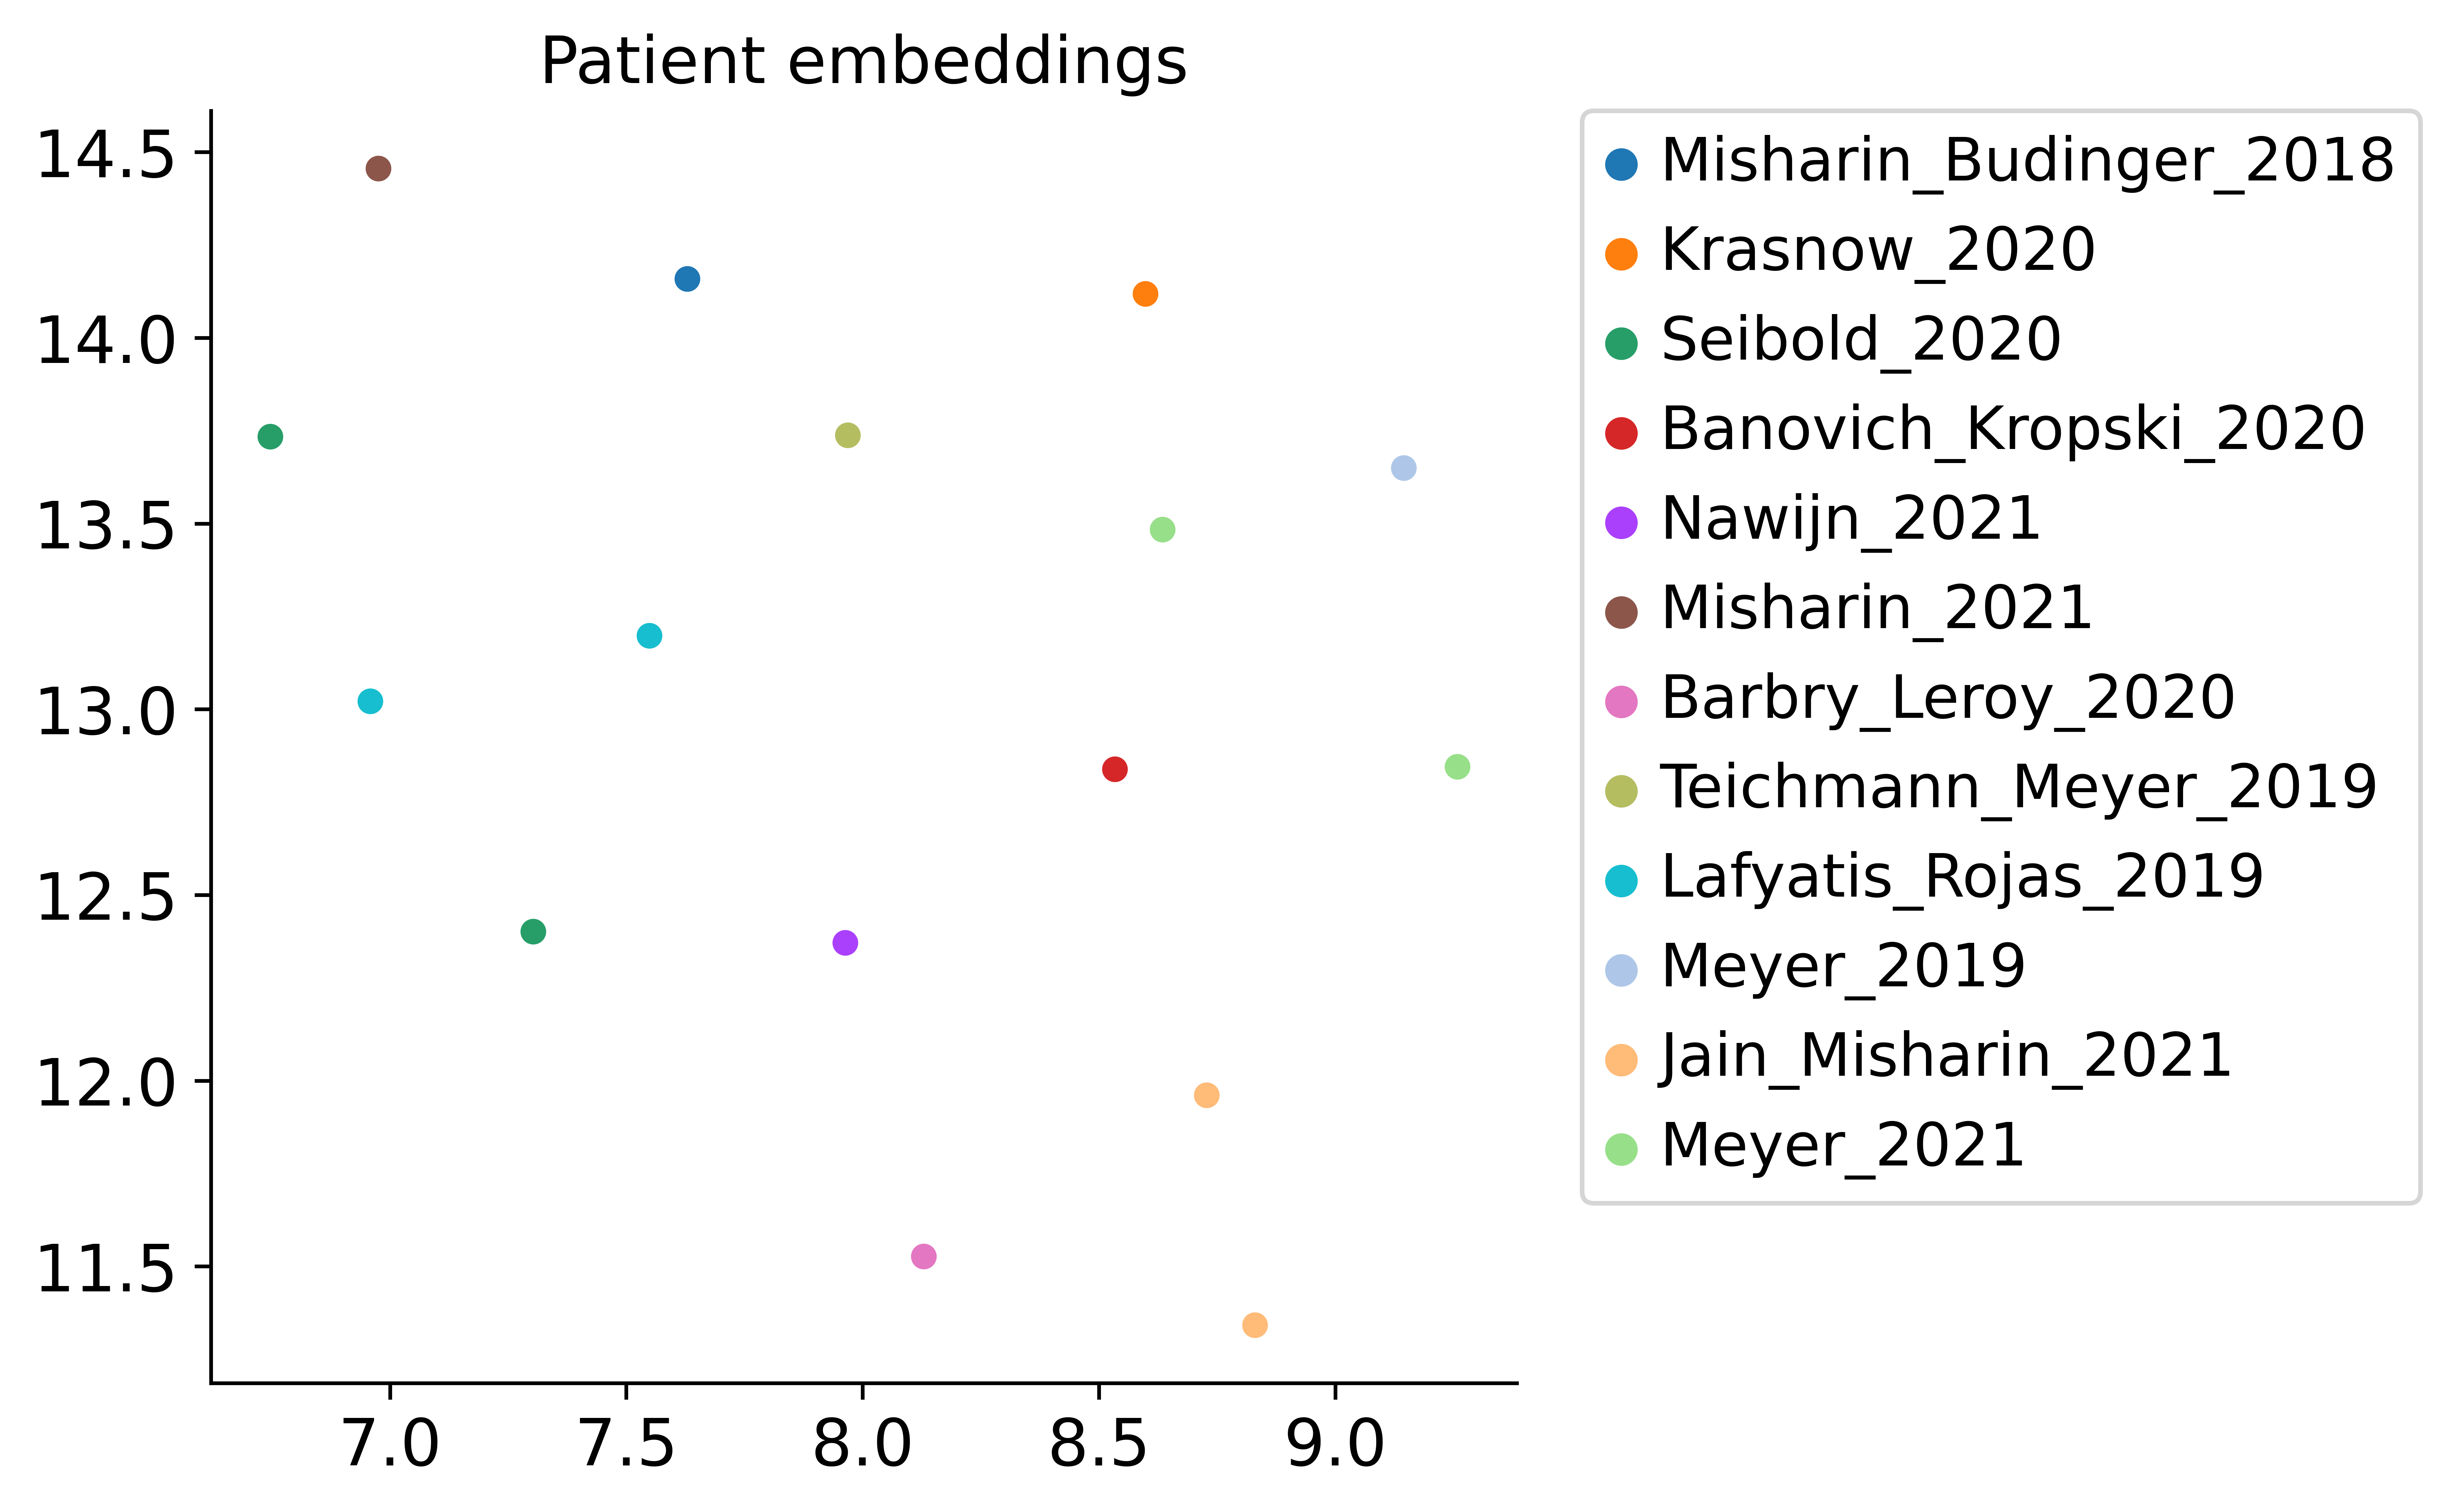

In [20]:
embedding_plot(lataq_query, 'dataset', emb_pca, adata_concat, [0, 1], 'study')